In [291]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from resample import bootstrap as bs
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
import sklearn.utils
import math

# Time Series Classification

In [2]:
def make_feature_dataset(length):
    df_name = pd.DataFrame()
    colnames = []
    for i in range(1, (length + 1)):
        colnames.append('min' + str(i))
        colnames.append('max' + str(i))
        colnames.append('mean' + str(i))
        colnames.append('median' + str(i))
        colnames.append('std' + str(i))
        colnames.append('1Q' + str(i))
        colnames.append('3Q' + str(i))
    df_name = pd.DataFrame(columns = colnames)
    df_name.index.name = 'instance'
    return df_name

In [73]:
def extract_features(dataframe_input, method = None) :
    
    dataframe = dataframe_input.copy()
    
    feature_num = len(list(filter(lambda x : x.find("rss") >= 0, dataframe.columns)))
    time_domain_feat = make_feature_dataset(feature_num)

    
        
    for dataset in dataframe.dataset.unique():
            
        time_domain_feat.index.insert(len(time_domain_feat), dataset)
        chunk = dataframe[dataframe.dataset == dataset]
        label = chunk.label.unique()[0]
        chunk = chunk.drop(filter(lambda x : x.find("rss") == -1, chunk.columns), axis = 1)
        time_domain_feat.loc[dataset, 'label'] = label
            
        for i in chunk.columns : 
                
            min_i = chunk.loc[:,i].min()
            max_i = chunk.loc[:,i].max()
            mean_i = chunk.loc[:,i].mean()
            median_i = chunk.loc[:,i].median()
            std_i = chunk.loc[:,i].std()
            fq_i = chunk.loc[:,i].quantile(.25)
            tq_i = chunk.loc[:,i].quantile(.75)
            
            idx = chunk.columns.tolist().index(i) + 1
            time_domain_feat.loc[dataset, 'min' + str(idx)] = min_i
            time_domain_feat.loc[dataset, 'max' + str(idx)] = max_i
            time_domain_feat.loc[dataset, 'mean' + str(idx)] = mean_i
            time_domain_feat.loc[dataset, 'median' + str(idx)] = median_i
            time_domain_feat.loc[dataset, 'std' + str(idx)] = std_i
            time_domain_feat.loc[dataset, '1Q' + str(idx)] = fq_i
            time_domain_feat.loc[dataset, '3Q' + str(idx)] = tq_i
        
    if(method == 'binary'):
        time_domain_feat.loc[time_domain_feat.label != 'bending', 'label'] = 1
        time_domain_feat.loc[time_domain_feat.label == 'bending', 'label'] = 0
        
            
    return time_domain_feat

In [56]:
def select_series(feature_df, which_series, which_features):
    
    selected = pd.DataFrame()
    selected['dataset'] = feature_df.index
    feature_df = feature_df.reset_index(drop = True)
    for f in which_features:
        for s in which_series:
            name = f + str(s)
            extract = feature_df[name]
            selected = selected.join(extract)
    selected['label'] = feature_df.label
    selected = selected.set_index('dataset')
    
    return selected

In [4]:
def break_time(breaks, dataset):
    
    colnames = []
    colnames.append(dataset.columns[1 : 7])
    for i in range(2 , breaks + 1):
        for j in dataset.columns[1 : 7]:
            colnames.append(j + '_' + str(i))
    new_time_series = pd.DataFrame()
    
    current_n = len(list(filter(lambda x : x.find("rss") >= 0, dataset.columns)))
    
    for curr_dataset in sorted(dataset.dataset.unique().tolist()):
        curr_file = dataset[dataset.dataset == curr_dataset]
        curr_label = curr_file.label.unique()[0]
        total_length = curr_file.shape[0]
        start_point = 0
        break_point = int(total_length / breaks)
        new_block = pd.DataFrame()
        num_break = 1
        
        while(break_point <= total_length): 
            curr_block = curr_file.iloc[start_point : break_point, : (current_n + 1)]
            curr_block = curr_block.reset_index(drop = True)
            
            if(new_block.empty) :
                new_block = new_block.append(curr_block)
            else:
                new_block = new_block.join(curr_block, rsuffix =  '_'+ str(num_break))
            
            if(num_break == breaks):
                new_block['dataset'] = curr_dataset
                new_block['label'] = curr_label
             
            num_break = num_break + 1
            start_point = break_point
            break_point += int(total_length / breaks)    
            
        
        new_time_series = new_time_series.append(new_block, sort = False)   
        
    return new_time_series

In [340]:
def transform_data(data, l, classification_method):
    
    data_series = break_time(l, data)
    data_features = extract_features(data_series)
    
    if(classification_method == 'binary'):
        data_features.loc[data_features.label != 'bending' , 'label'] = 1
        data_features.loc[data_features.label == 'bending' , 'label'] = 0
    elif(classification_method == 'multi'):
        for i in range(len(data_features.label.unique())):
            data_features.loc[data_features.label == data_features.label.unique()[i], 'label'] = i
    else:
        print(error)
    x = data_features.iloc[:,:-1].reset_index(drop = True)
    y = list(data_features.label.reset_index(drop = True))

    return x, y


In [5]:
def get_optimal_lp(l_p_score):
    
    best_score = -math.inf
    l = None
    p = None
    
    for x in l_p_score:
        if(l_p_score[x] >= best_score):
            best_score = l_p_score[x]
            l = x[0]
            p = x[1]
    
    return l, p

In [7]:
def log_reg(x, y, method, l = None, classification_method = None, estimator = None, cv_method = None, p = None, accuracy = None):

    
    if(method == 'cross_validate'):
        
        rfecv = RFECV(estimator, cv = cv_method, scoring = 'f1')
        rfecv = rfecv.fit(x,y)
        score = np.mean(rfecv.grid_scores_)
        p = rfecv.n_features_
        accuracy[(l,p)] = score
        return accuracy
    
    elif(method == 'train'):
        
        rfe = RFE(estimator, n_features_to_select = p)
        model_log = rfe.fit(x,y)
        return model_log
    
    else:
        print("Wrong parameter passed")
        

In [193]:
def see_density(data, name) :
    
    num_feats = (len(data.columns) / 7)
    dens_fig = plt.figure(figsize = (25, num_feats * 20))
    dens_fig.subplots_adjust(hspace = .4, wspace = .2)
    palette = sns.color_palette("husl", 8)
    
    for i in range(0, len(data.columns) - 1):
        dens_fig.add_subplot(len(data.columns),num_feats, (i + 1))
        x1 = data.loc[data.label == 0, data.columns[i]]
        x2 = data.loc[data.label == 1, data.columns[i]]
        sns.kdeplot(x1)
        sns.kdeplot(x2)
        plt.legend(('bending', 'other'))
        plt.title(data.columns[i])
    plt.savefig(name, bbox_inches = 'tight', pad_inches = .3)

In [8]:
# loading data 
# change directory to data
os.chdir('/Users/yunie/Documents/USC/2019_Fall/INF_552_machine_learning/INF552_hw3')
home_dir = os.getcwd()

error_files = []
file_names = []
dataframes = []

for fn in sorted(os.listdir(home_dir)):
    if (fn.find('.') == -1):
        foldername = home_dir + '/' + fn
        os.chdir(foldername)
        for file in sorted(os.listdir(foldername)):
            if('csv' in file and 'dataset' in file):
                instance = fn + '_' + os.fsdecode(file).split(".")[0]
                try:
                    dataset = pd.read_csv(file, skiprows = 4)
                    
                    if(dataset.isnull().values.any()):
                        error_files.append(foldername + '/' + file)
                    else:
                        file_names.append(instance)
                        dataframes.append(dataset)
                except:
                    error_files.append(foldername + '/' + file)    
os.chdir(home_dir)

In [9]:
#clean dataset bending2 dataset4
bending2_dataset4 = pd.read_csv(error_files[0], skiprows = 4)
columns = bending2_dataset4.columns
bending2_dataset4 = bending2_dataset4[bending2_dataset4.columns[0]].str.split(expand = True).astype(float)
bending2_dataset4.set_axis(columns, axis = 1, inplace = True)
file_names.append('bending2_dataset4')
dataframes.append(bending2_dataset4)

In [14]:
#make dataframe containing all datasets
data_full = pd.DataFrame()

for i in range(len(file_names)):
    dataframes[i]['dataset'] = file_names[i]
    if(file_names[i].find('bending') >= 0):
        dataframes[i]['label'] = 'bending'
    else:
        dataframes[i]['label'] = file_names[i].split('_')[0]
    data_full = data_full.append(dataframes[i], ignore_index = True)

In [15]:
#split train/test data
train = pd.DataFrame()
test = pd.DataFrame()


for file in data_full.dataset.unique():
    chunk = data_full[data_full.dataset == file]
    try:
        int(file[-2:])
        train = train.append(chunk)
    except:
        if(int(file[-1]) == 1 or int(file[-1]) == 2):
            test = test.append(chunk)
        elif(chunk.label.unique()[0] != 'bending'):
            if(int(file[-1]) == 3):
                test = test.append(chunk)
            else:
                train = train.append(chunk)
        else:
            train = train.append(chunk)
                
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

print(train.dataset.to_string())
print(test.dataset.to_string)

In [155]:
time_domain_feats = extract_features(data_full)


In [48]:
#bootstrap

bootstrap = pd.DataFrame(columns = time_domain_feats.columns[:-1], index = ['std', 'confidence interval'])
 
for i in range(0 , len(bootstrap.columns)) :
    bootstrap.loc['std', bootstrap.columns[i]] = np.std(time_domain_feats[time_domain_feats.columns[i]])
    bootstrap.loc['confidence interval', bootstrap.columns[i]] = bs.bootstrap_ci(time_domain_feats[time_domain_feats.columns[i]], f = np.std, p = .9, b = 1000)

bootstrap

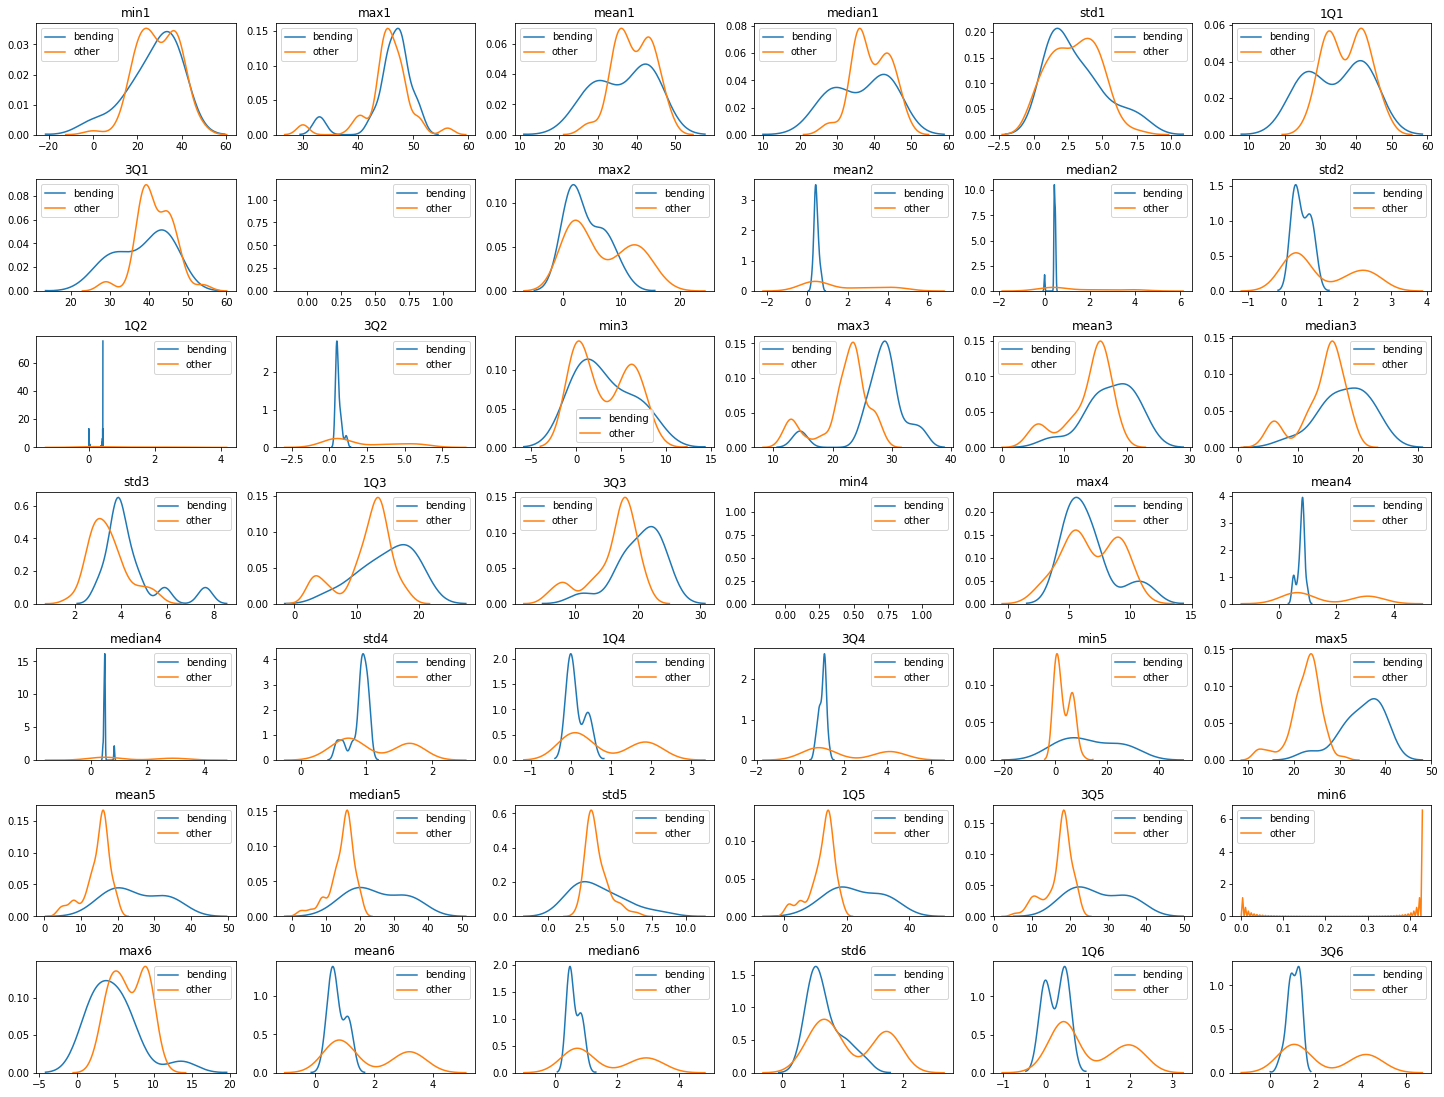

In [194]:
features_binary = extract_features(data_full, 'binary')
features_density_plot = see_density(features_binary, 'features_density.png')

In [218]:
train_binary = extract_features(train, 'binary')
one_two_six = select_series(train_binary, [1,2,6], ['median', '1Q', '3Q'])

<Figure size 1440x720 with 0 Axes>

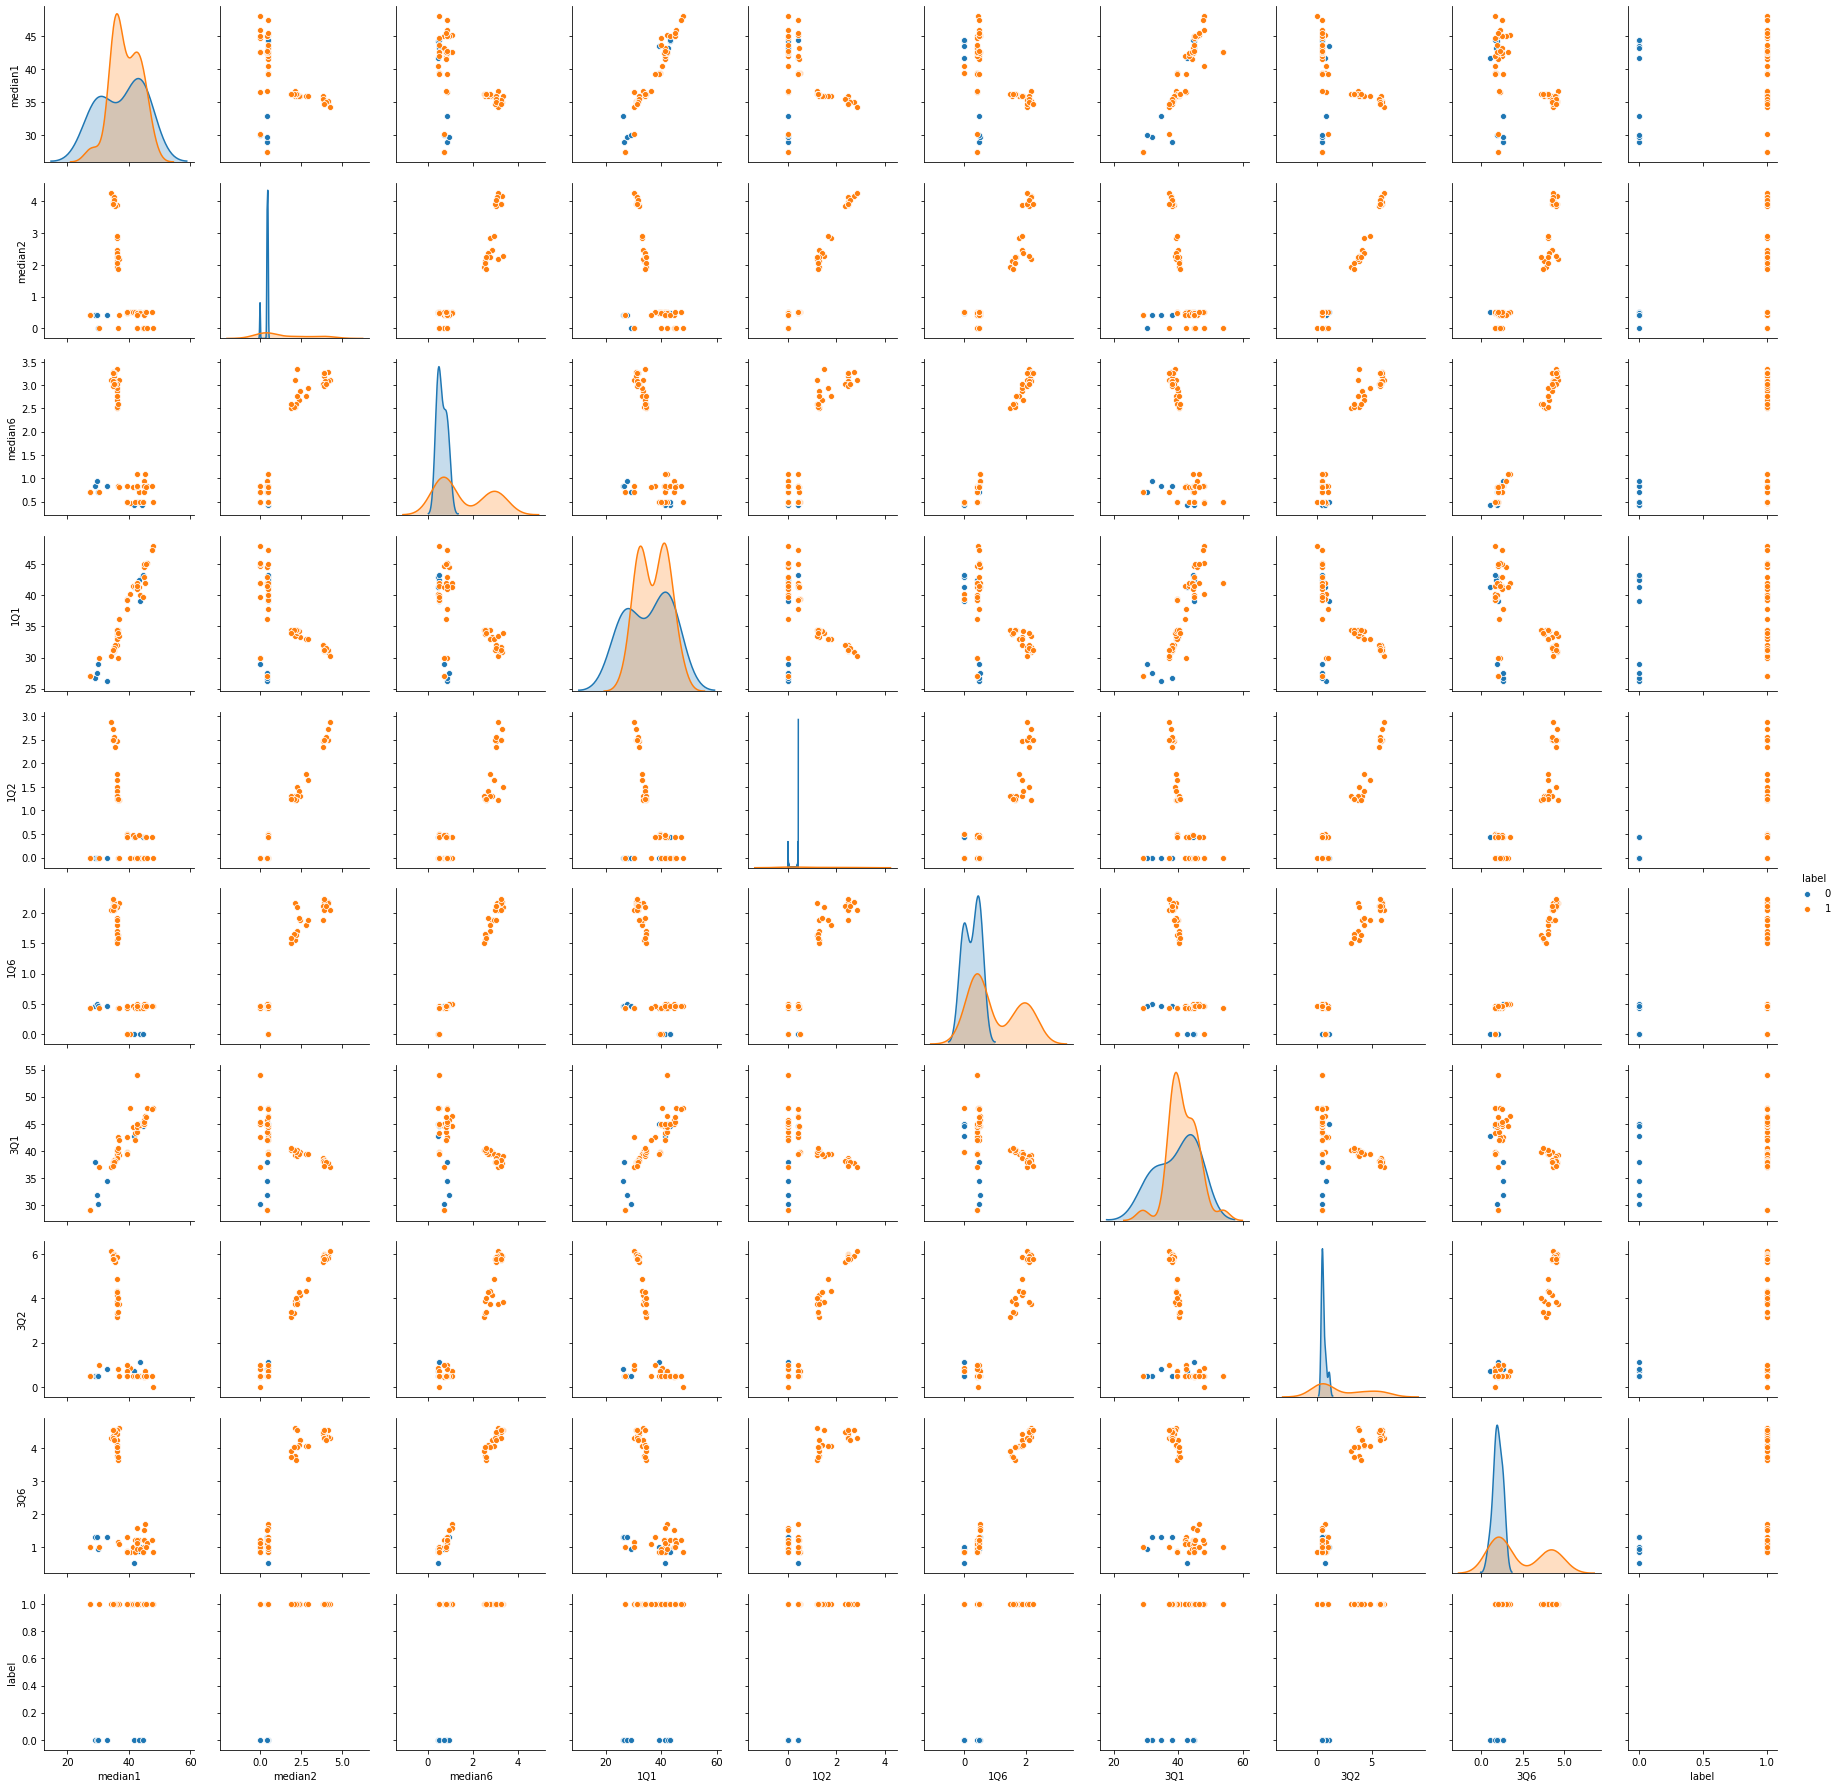

In [219]:
#scatterplot of binary_features
fig_scatterplot_binary = plt.figure(figsize = (20, 10))
scatterplot_binary = sns.pairplot(one_two_six, hue = 'label')
plt.savefig('binary_scatterplot.png')

In [221]:
break_two = break_time(2, train)
features_break_two = extract_features(break_two, 'binary')
one_two_twelve = series_select(features_break_two, [1,2,12], ['median', '1Q', '3Q'])

<Figure size 1440x720 with 0 Axes>

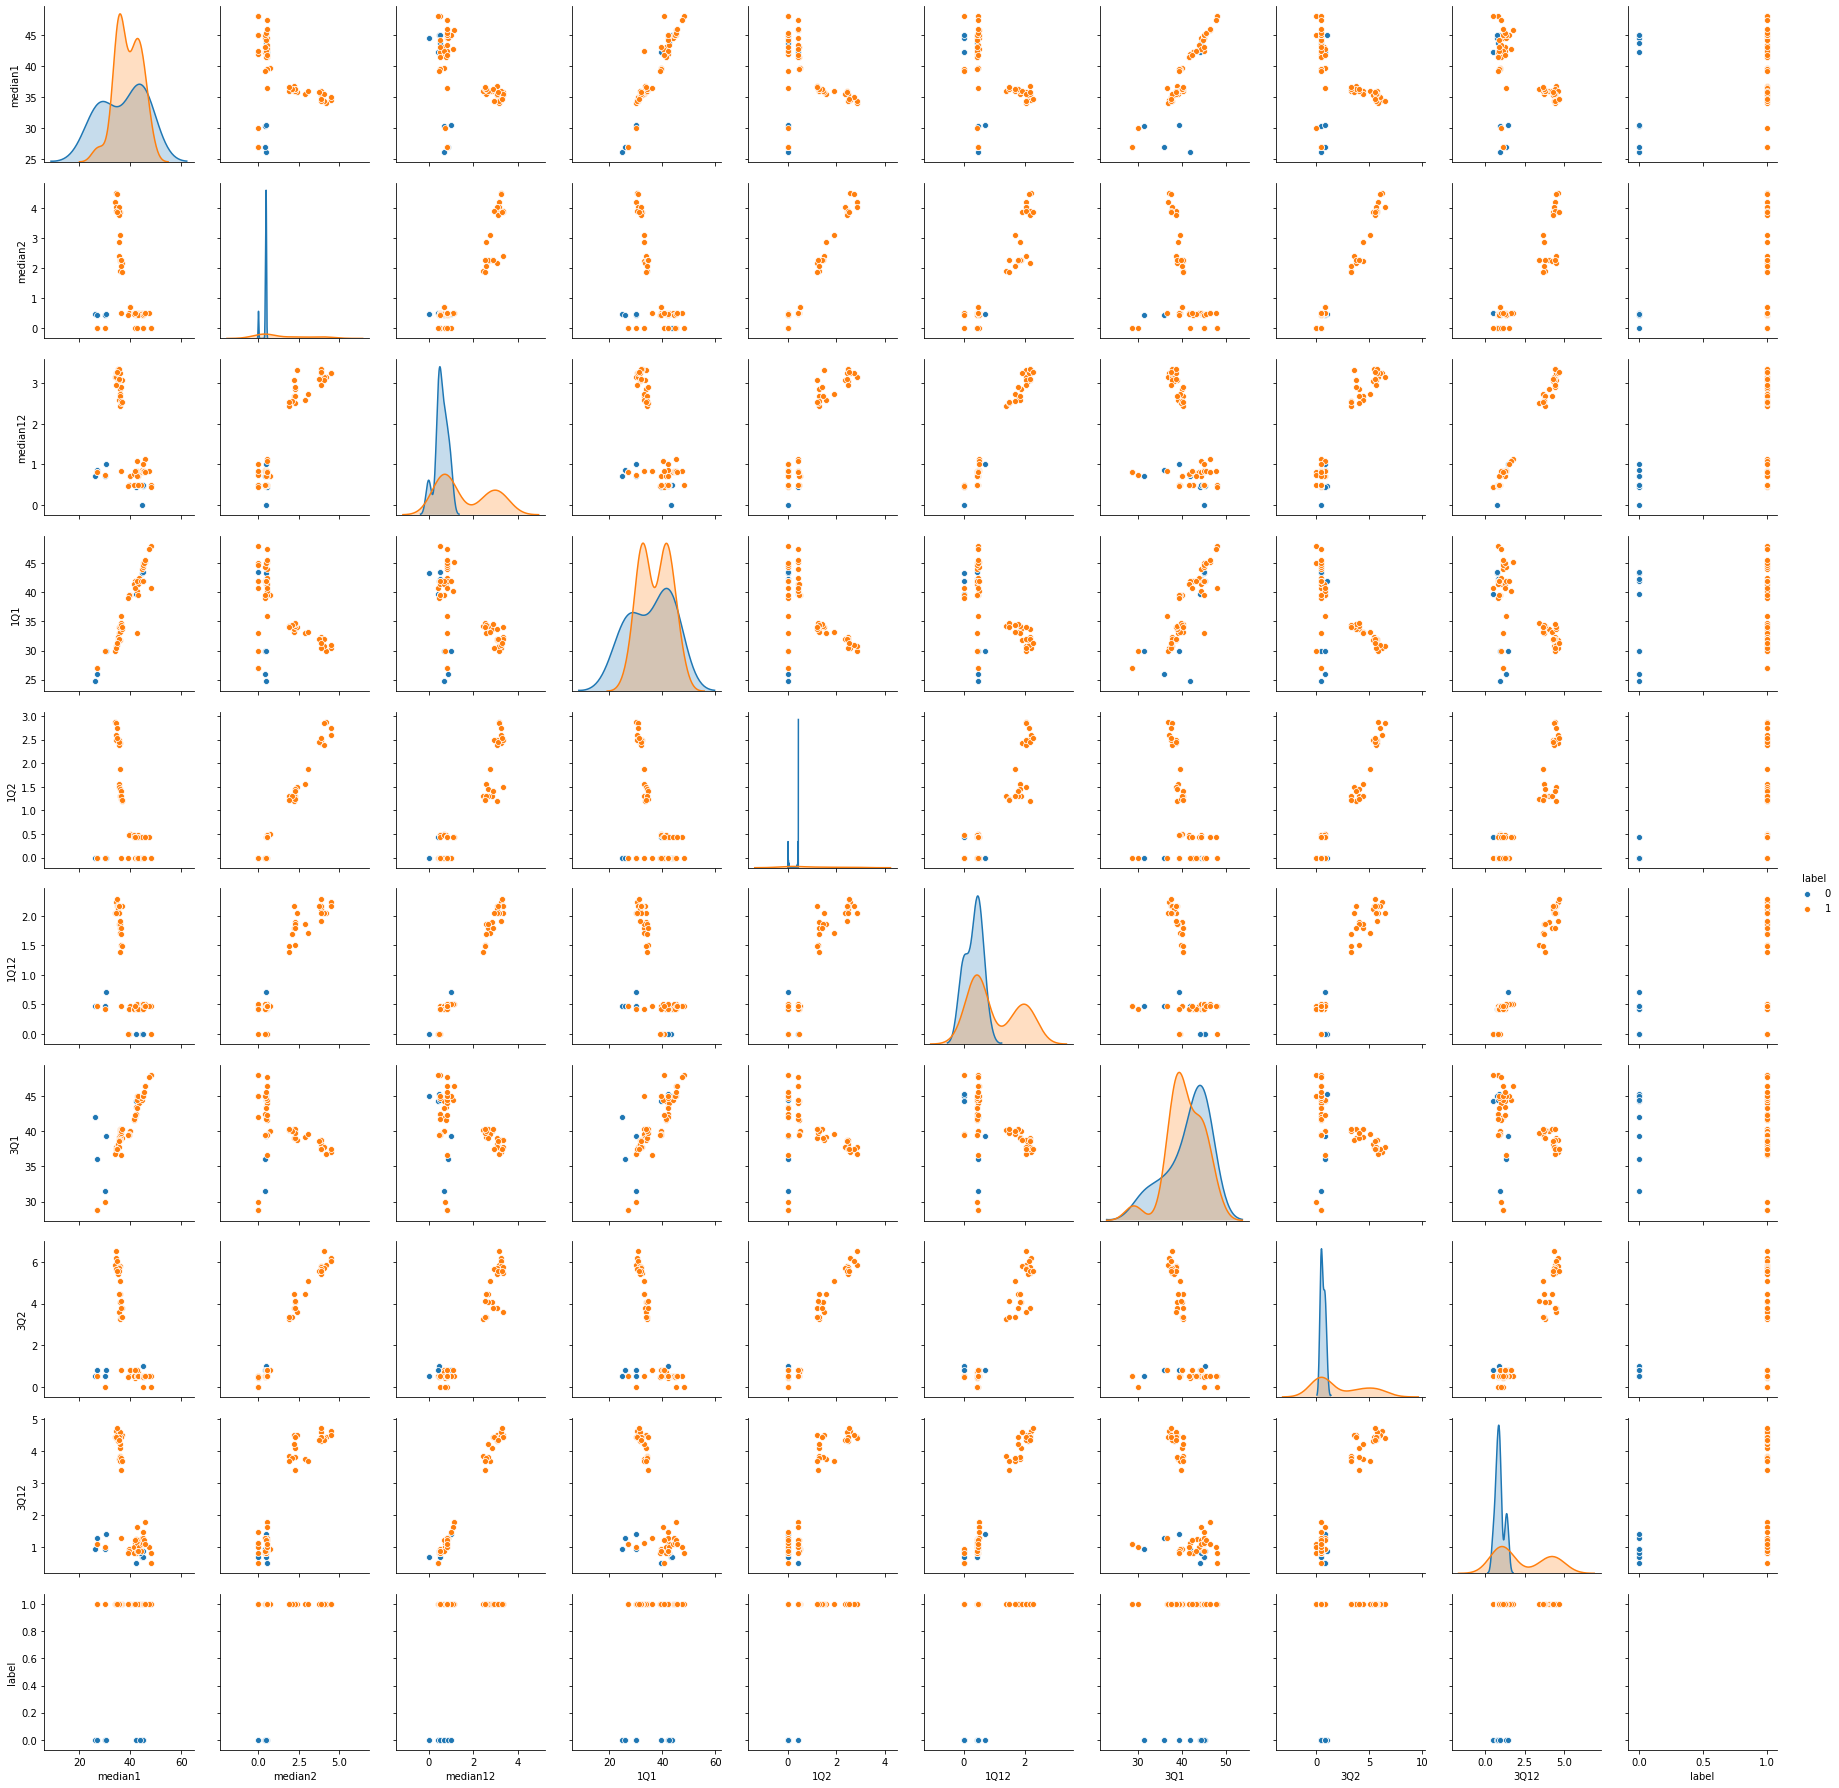

In [222]:
fig_scatterplot_1212 = plt.figure(figsize = (20, 10))
scatterplot_1212 = sns.pairplot(one_two_twelve, hue = 'label')
plt.savefig('scatterplot_1212.png')


In [20]:
#getting best (l,p) value
skf = StratifiedKFold(n_splits = 5, shuffle = True)
estimator_log_reg = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 10000)
l_p_score = {}        


for l in range(1, 21):
    
    x_train, y_train = transform_data(train, l, classification_method = 'binary')
    log_reg(x_train, y_train, method = 'cross_validate', classification_method = 'binary', estimator = estimator_log_reg, 
            cv_method = skf , l = l, accuracy = l_p_score) 

l, p = get_optimal_lp(l_p_score)        

In [243]:
# fit training set
x_train, y_train = transform_data(train, l, classification_method = 'binary')
binary_reg_model = log_reg(x_train, y_train, classification_method = 'binary', 
                           estimator = estimator_log_reg, method = 'train', l = l, p = p)
selected_features = x_train.columns[binary_reg_model.support_]
x_train_selected = x_train.loc[:,selected_features]
binary_log_reg_model = estimator_log_reg.fit(x_train_selected, y_train)
y_train_predict = binary_log_reg_model.predict(x_train_selected)

In [244]:
metrics.confusion_matrix(y_train, y_train_predict)

#p_values = binary_log_reg_model.predict_proba(x_train_selected)

array([[ 9,  0],
       [ 0, 60]])

In [287]:
p_values = pd.DataFrame(chi2(x_train_selected, y_train)[1]).transpose()
p_values.columns = selected_features
p_values['result'] = 'p value'
coefficients = pd.DataFrame(data = binary_log_reg_model.coef_, columns = selected_features)
coefficients['result'] = 'coefficients'
result = coefficients.append(p_values)
result.set_index('result')

mean1       3Q1     max2          min5          max5  \
result                                                                  
coefficients  1.711939  2.467214  2.25715 -2.977329e+00 -3.225446e+00   
p value       0.516023  0.399688  0.00121  2.789824e-36  3.221813e-12   

                     mean5           1Q5  
result                                    
coefficients -1.601649e+00 -1.669636e+00  
p value       1.940859e-11  3.924034e-13

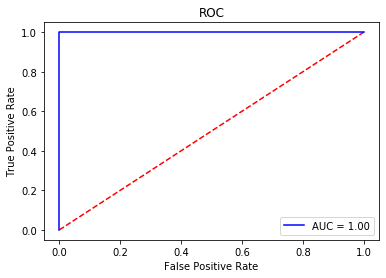

In [234]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_predict)
metrics.auc(fpr, tpr)
roc_auc = metrics.roc_auc_score(y_train, y_train_predict)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.savefig('roc_auc.png')

In [289]:
#test model on test data

x_test, y_test = transform_data(test, l, classification_method = 'binary')
x_test_selected = x_test.loc[ : , selected_features]
y_test_predict = binary_log_reg_model.predict(x_test_selected)
metrics.confusion_matrix(y_test, y_test_predict)

array([[ 4,  0],
       [ 0, 15]])

In [320]:
estimator_l1_reg = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', cv = skf, max_iter = 10000)
estimator_l1_reg.fit(x_train, y_train)
type(np.mean(estimator_l1_reg.scores_[1]))

numpy.float64

In [316]:
#normalize data for logistic regression
train_x_normalize = train.copy()
cols = train_x_normalize.columns[1:7].copy()
ds = train_x_normalize.iloc[:,-2].copy()
labels = train_x_normalize.iloc[:,-1].copy()
train_x_normalize = normalize(train_x_normalize.iloc[ : , 1:7])

#put normalized data into dataframe
time = train.iloc[:,0].copy()
time_name = train.columns[0]
train_nor = pd.DataFrame(columns = cols, data = train_x_normalize)
train_nor.insert(0, time_name, time)
train_nor = train_nor.join(ds)
train_nor = train_nor.join(labels)


In [330]:
#normalize data for logistic regression
test_x_normalize = test.copy()
cols_test = test_x_normalize.columns[1:7].copy()
ds_test = test_x_normalize.iloc[:,-2].copy()
labels_test = test_x_normalize.iloc[:,-1].copy()
test_x_normalize = normalize(test_x_normalize.iloc[ : , 1:7])

#put normalized data into dataframe
time_test = test.iloc[:,0].copy()
time_name_test = test.columns[0]
test_nor = pd.DataFrame(columns = cols, data = test_x_normalize)
test_nor.insert(0, time_name_test, time_test)
test_nor = test_nor.join(ds_test)
test_nor = test_nor.join(labels_test)

In [323]:
estimator_l1_reg = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', cv = skf, max_iter = 100000)
l_c = {}    

for l in range(1, 21):
    
    x_train, y_train = transform_data(train_nor, l, classification_method = 'binary')
    estimator_l1_reg.fit(x_train, y_train)
    c = float(estimator_l1_reg.C_)
    score = np.mean(estimator_l1_reg.scores_[1])
    l_c[(l,c)] = score

l_l1, c = get_optimal_lp(l_c)        

In [328]:
model_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = c, max_iter = 10000)

x_train, y_train = transform_data(train_nor, l_l1, classification_method = 'binary')
model_l1.fit(x_train, y_train)

LogisticRegression(C=166.81005372000558, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l1', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

In [334]:
y_train_predict = model_l1.predict(x_train)
metrics.confusion_matrix(y_train, y_train_predict)

array([[ 9,  0],
       [ 0, 60]])

In [331]:
x_test, y_test = transform_data(test_nor, l_l1, classification_method = 'binary')
y_test_predict = model_l1.predict(x_test)
metrics.confusion_matrix(y_test, y_test_predict)

array([[ 3,  1],
       [ 0, 15]])

In [ ]:
estimator_l1_multi = LogisticRegressionCV(penalty = 'l1', solver = 'saga', cv = skf, multi_class = 'multinomial', max_iter = 100000)
l_c_multi = {}

for l in range(1, 21):
    
    x_train, y_train = transform_data(train_nor, l, classification_method = 'multi')
    estimator_l1_multi.fit(x_train, y_train)
    c = float(estimator_l1_multi.C_[0])
    score = np.mean(estimator_l1_multi.scores_[1])
    l_c_multi[(l,c)] = score

l_multi, c_multi = get_optimal_lp(l_c)    

# Report
#### (a) Feature Extraction
##### i. Research what types of time-domain features are usually used in time series classification and list them 
    Mean
    Zero crossing rate
    Maxima/Minima
    Autocorrelation
    Cross-correlation
    Linear correlation coefficient
    Standard deviation

##### ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance.

    Defined function:
``` python
    def extract_features(data)
``` 
    to extract time-domain features from data.
    The result is stored as 'time_domain_feats'

##### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.    

    code:
``` python
    bootstrap = pd.DataFrame(columns = time_domain_feats.columns[:-1], index = ['std', 'confidence interval'])
 
    for i in range(0 , len(bootstrap.columns)) :
        bootstrap.loc['std', bootstrap.columns[i]] = np.std(time_domain_feats[time_domain_feats.columns[i]])
        bootstrap.loc['confidence interval', bootstrap.columns[i]] =
            bs.bootstrap_ci(time_domain_feats[time_domain_feats.columns[i]], f = np.std, p = .9, b = 1000)

``` 
    The standard deviation and its bootstrap confidence of each feature is stored as 'bootstrap'

##### iv. Use your judgement to select the three most important time-domain features 
<img src = "features_density.png">

    The plot above shows the distribution of each time_domain features, where the blue line shows the distribution of class 'bending' and the orange line depicts 'other' classes. Since this is a classification problem, it would be better to choose features that distinguish the two classes. In other words, features that have a big difference in distribution. According to the plot above, 'Median', 'First quartlie', and 'Third quartile' seems to be important features for this problem.
    
#### (b) Binary Classification Using Logistic Regression
##### i. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.
<img src = "binary_scatterplot.png">

##### ii. Break each time series in your training set into two (approximately) equal length time series.
    Defined function:
``` python
    def break_time(breaks, dataset):
```
    breaks each dataset(time series) into breaks
    The dataframe where each time series in the training set was broken into two is saved as 'features_break_two'
##### Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12
##### Do you see any considerable difference in the results with those of 1(d)i?
<img src = "scatterplot_1212.png">

    Although the two plots are not identical, the plot above is not significantly different from 1(d)i

##### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. ... You can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination.
     I used backward selection with RFECV using stratified k-fold cross-validation as cross-validation method. I used stratified k-fold cross-validation since there are way more 'other' classes than 'bending. Stratified k-fold cross-validation method can mitigate this problem by making sure that each k-fold maintains at least certain instances of rare classes. 
     The optimal (l,p) was (1,5) with 0.9886300318039448 mean cross-validation accuracy score and 1.0 train accuracy score. The selected features were mean1, third-quartile3, max2, min5, max5, mean5, and	first-quartile5
     (this result is prone to change everytime the we run the code since I did not set seed).

    code:
``` python 
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    estimator_log_reg = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 10000)
    l_p_score = {}        

    #following for loop is within function 'log_reg'
    for l in range(1, 21):
    
        rfecv = RFECV(estimator, cv = cv_method, scoring = 'f1')
        rfecv = rfecv.fit(x,y)
        score = np.mean(rfecv.grid_scores_)
        p = rfecv.n_features_
        accuracy[(l,p)] = score
        return accuracy
    
    l, p = get_optimal_lp(l_p_score)
    
    x_train, y_train = transform_data(train, l, classification_method = 'binary')
    binary_reg_model = log_reg(x_train, y_train, classification_method = 'binary', 
                           estimator = estimator_log_reg, method = 'train', l = l, p = p)
    y_train_predict = binary_reg_model.predict(x_train)
```    
##### Explain what the right way and the wrong way are to perform cross-validation in this problem.
    The right way to perform cross-validation in this problem is to first find optimal the parameters (l,p) using k-fold cross-validation, and then train the model again using the parameters on the whole training data. The wrong way is to select features before training and then perform cross-validation.
    
##### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.
    Confusion matrix: 
          
            9 | 0
            -----
            0 |60
    
    train accuracy = 1
    
    ROC-AUC:
<img src = "roc_auc.png">
    
    
                mean1	    3Q1	      max2	       min5	        max5	        mean5	       1Q5
							
    params    1.711939	 2.467214	2.25715	  -2.977329e+00	-3.225446e+00	-1.601649e+00	-1.669636e+00
    p value	  0.516023	 0.399688	0.00121	  2.789824e-36	3.221813e-12	1.940859e-11	3.924034e-13

##### v. Test the classifier on the test set.Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.
    Confusion matrix:
            
            4 | 0
            -----
            0 |15
     
    The test accuarcy is also 1 (same as test accuracy)
    And higher than the cros-validation accuracy(0.9886300318039448)
##### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
    Yes. The classes seem to be well-separated, so I had to set max_iter to a huge number 
##### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.
    yes, it shows conditional imbalance between classes
#### (c) Binary Classification Using L1-penalized logistic regression
##### i. Repeat 1(d)iii using L1-penalized logistic regression
``` python
    estimator_l1_reg = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', cv = skf, max_iter = 100000)
    l_c = {}    

    for l in range(1, 21):
    
        x_train, y_train = transform_data(train_nor, l, classification_method = 'binary')
        estimator_l1_reg.fit(x_train, y_train)
        c = float(estimator_l1_reg.C_)
        score = np.mean(estimator_l1_reg.scores_[1])
        l_c[(l,c)] = score

    l_l1, c = get_optimal_lp(l_c)      
```    
    l_11 = 20, c = 166.81005372000558

##### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?
    Variable selection using p-values perform better than L1 penalized logistic regression, but L1 penalized logistic regression is easier to implement

    L1-penalized test confusion matrix
        
            3 | 1
            -----
            0 |15
    
    Backward selection using p-values confusion matrix:
            
            4 | 0
            -----
            0 |15



